## Adversarial-validation

#### In this coursework, we know that the test set and the training set are two different distributions. Thus, I want to use a basic model to find whethere  the model can identify images from different sets. The AUC is good criterion to apply this work

In [67]:
import os, sys
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import albumentations as A

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from imblearn import over_sampling, under_sampling, combine
from sklearn.metrics import roc_auc_score as AUC
from sklearn import metrics
import pylab as plt
import warnings;warnings.filterwarnings('ignore')

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [41]:
PATH='./checkpoint/'

## Functions

In [54]:
class ImageDataset(Dataset):
    def __init__(self, img_df, transform=None):
        self.img_df = img_df
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        img = Image.open(self.img_df.iloc[index]['Id']).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        return img,torch.from_numpy(np.array(self.img_df.iloc[index]['Type']))
    
    def __len__(self):
        return len(self.img_df)

In [53]:
class ImageDataset_Adversarial(Dataset):
    def __init__(self, img_df, transform=None):
        self.img_df = img_df
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        img = Image.open(self.img_df.iloc[index]['Path']).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        return img,torch.from_numpy(np.array(self.img_df.iloc[index]['is_test']))
    
    def __len__(self):
        return len(self.img_df)

In [57]:
class CellNet(nn.Module):
    def __init__(self):
        super(CellNet, self).__init__()
                
        model_conv = models.resnet34(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)
        model_conv = nn.Sequential(*list(model_conv.children())[:-1])
        self.cnn = model_conv
        self.fc = nn.Linear(512, 2)
        
    def forward(self, img):        
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        out = self.fc(feat)
        return out

In [5]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def accuracy(output, target, topk=(1, 2)):
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k / batch_size)
    return res

In [44]:
def train(train_loader, model, criterion, optimizer):
    # switch to train mode
    model.train()

    losses = AverageMeter()
    top1 = AverageMeter()
    top2 = AverageMeter()

    for inputs, targets in train_loader:

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec2 = accuracy(outputs, targets, topk=(1, 2))
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1.item(), inputs.size(0))
        top2.update(prec2.item(), inputs.size(0))

        # compute gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return (losses.avg, top1.avg, top2.avg)

In [45]:
def val(val_loader, model, criterion):

    losses = AverageMeter()
    top1 = AverageMeter()
    top2 = AverageMeter()

    # switch to evaluate mode
    model.eval()
    for inputs, targets in val_loader:

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec2 = accuracy(outputs, targets, topk=(1, 2))
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1.item(), inputs.size(0))
        top2.update(prec2.item(), inputs.size(0))

    return (losses.avg, top1.avg, top2.avg)

In [9]:
def predict(test_loader, model, tta=1):
    # switch to evaluate mode
    model.eval()

    test_pred_tta = None
    for _ in range(tta):
        test_pred = []
        with torch.no_grad():
            for i, (input,target) in enumerate(test_loader):
                input = input.to(device)
                # compute output
                output = model(input)
                output = output.data.cpu().numpy()

                test_pred.append(output)
        test_pred = np.vstack(test_pred)
    
        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred
    
    return test_pred_tta

In [78]:
def predict_val(test_loader, model, tta=1):
    # switch to evaluate mode
    model.eval()

    test_pred_tta = None
    for _ in range(tta):
        test_pred = []
        with torch.no_grad():
            for i, (input,target) in enumerate(test_loader):
                input = input.to(device)
                # compute output
                output = model(input)
                probs = F.softmax(output, dim=1)
                probs = probs.data.cpu().numpy()[:,1]
                test_pred=np.hstack((test_pred,probs))
    
    return test_pred

In [12]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    mean = torch.zeros(3).to(device)
    std = torch.zeros(3).to(device)
    print('==> Computing mean and std..')
    for inputs in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean().to(device)
            std[i] += inputs[:,i,:,:].std().to(device)
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

In [13]:
class TestDataset(Dataset):
    
    def __init__(self, img_path, transform=None,img_label=None, ):
        self.img_path = img_path
        self.img_label = img_label
        
        if img_label is not None:
            self.img_label = torch.LongTensor(img_label)
            
        self.transform = transform
        
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, index):
        img = Image.open(self.img_path[index])
        if self.transform is not None:
            img = self.transform(img)
        if self.img_label is not None:
            label = self.img_label[index]
            return img, label
        else:
            return img

### Load the dataset

**set the trainset as '0' class and the testset as '1' class**

In [29]:
train_label=pd.read_csv('../input/deep-learning-for-msc-coursework-2021/train.csv')
train_label['Path']= train_label['Id'].apply(lambda x: '../input/deep-learning-for-msc-coursework-2021/train/train/'+str(x)+'.png')
train_label['is_test']=0

In [30]:
test_label=pd.read_csv('../input/deep-learning-for-msc-coursework-2021/example.csv')
test_label['Path']= test_label['Id'].apply(lambda x: '../input/deep-learning-for-msc-coursework-2021/test/test/'+str(x)+'.png')
test_label['is_test']=1

In [31]:
test_df = pd.concat([train_label,test_label])

In [33]:
test_df.head()

,Id,Type,Path,is_test
0,1,Connective,../input/deep-learning-for-msc-coursework-2021...,0
1,2,Connective,../input/deep-learning-for-msc-coursework-2021...,0
2,3,Connective,../input/deep-learning-for-msc-coursework-2021...,0
3,4,Connective,../input/deep-learning-for-msc-coursework-2021...,0
4,5,Connective,../input/deep-learning-for-msc-coursework-2021...,0


In [34]:
test_df['is_test'].value_counts()

0    2190
1     400
Name: is_test, dtype: int64

In [42]:
MODEL_NAME='Adversarial_Validation'

### Use the basic model to do Kfold and get the best model which get the higest auc scores

In [58]:
best_auc=0
skf = KFold(n_splits=5, random_state=42, shuffle=True)
for flod_idx, (train_idx, val_idx) in enumerate(skf.split(test_df['Id'].values)):
    train_loader = DataLoader(
            ImageDataset_Adversarial(test_df.iloc[train_idx],
                transforms.Compose([
                            transforms.Resize((256, 256)),
                            transforms.RandomCrop((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        ), batch_size=32, shuffle=True, num_workers=4, pin_memory=True
    )
    val_loader = DataLoader(
        ImageDataset_Adversarial(test_df.iloc[val_idx],
                transforms.Compose([
                            transforms.Resize((256, 256)),
                            transforms.RandomCrop((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        ), batch_size=32, shuffle=False, num_workers=4, pin_memory=True 
    )

    model = CellNet().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=False)
    num_epoch=15
    for epoch in range(num_epoch):
        train_loss, train_acc, train_2 = train(train_loader, model, criterion, optimizer)
        val_loss, val_acc, val_2 = val(val_loader, model, criterion)
        scheduler.step(val_loss)
    val_pred = predict(val_loader, model)    
    val_pred = np.argmax(val_pred, 1)
    auc = AUC( val_pred, test_df['is_test'].iloc[val_idx].values )
    # save model
    if best_auc < auc:
        best_auc = auc
        state = {
            'model': model.state_dict(),
            'auc': best_auc,
        }
        torch.save(state, PATH + MODEL_NAME + '.pth')
    
    print('fold {}'.format(flod_idx+1),'AUC: {:.2%}\n'.format(auc))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

fold 1 AUC: 79.18%

fold 2 AUC: 81.82%

fold 3 AUC: 78.06%

fold 4 AUC: 81.63%

fold 5 AUC: 79.50%



### As we can see above, the AUC is too high. Thus, the distributions of the trainset and testset are so different. Therefore, we should find the images which are similar to the test set from the trainset and use those as the val set

In [63]:
test_pred = None
model_path=PATH + MODEL_NAME + '.pth'

test_loader = DataLoader(
    ImageDataset_Adversarial(test_df.iloc[val_idx],
                             transforms.Compose([
                                 transforms.Resize((256, 256)),
                                 transforms.RandomCrop((224, 224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])
                             ), batch_size=32, shuffle=False, num_workers=4, pin_memory=True
)
   
model = CellNet().to(device)
model.load_state_dict(torch.load(model_path)['model'])

<All keys matched successfully>

In [64]:
val_pred = predict(test_loader, model)    
val_pred = np.argmax(val_pred, 1)

### The Validation Auc is too high which reach 0.876

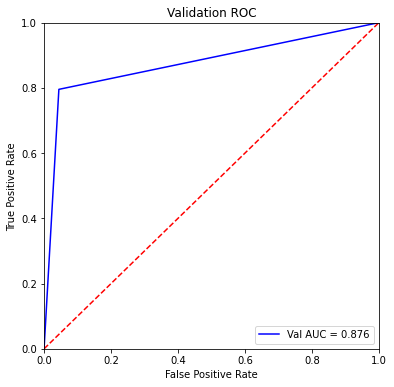

In [66]:
fpr, tpr, threshold = metrics.roc_curve(val_pred, test_df['is_test'].iloc[val_idx].values)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [68]:
full_loader = DataLoader(
    ImageDataset_Adversarial(test_df,
                             transforms.Compose([
                                 transforms.Resize((256, 256)),
                                 transforms.RandomCrop((224, 224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])
                             ), batch_size=32, shuffle=False, num_workers=4, pin_memory=True
)

### save the sorted train and use this new train set to train our models

In [84]:
full_pred = predict_val(full_loader, model)    
test_df['prob']=full_pred

In [85]:
train_label['prob']=test_df.loc[ test_df.is_test ==0 ]['prob']

In [86]:
num_sorted=np.argsort(train_label['prob'])

In [87]:
train_sorted = train_label.iloc[num_sorted]

In [88]:
train_sorted.to_csv('./train_sorted.csv')